# GANs In Action
## Chapter 2: Autoencoder
This is the accompanying code for the upcoming book _GANs in Action Deep Learning with Generative Adversarial Networks (GANs)_ by Manning Books. 

This tutorial was adapted from the [following tutorial](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py), which was published under MIT license.

## Why Colab?
Google Colabotary is an amazing way to run [Jupyter notebooks](http://jupyter.org) online, sprinkled on top with some Google goodness. We chose this environment, because it is compatible with the industry standard Jupyter notebooks but can be run by anyone with zero setup. But you are free to switch between the two commands as required.

## Why autoencoders? 
Well for that you'd need to buy the book ;) 

## Let's get started! 
And the only way to get started is with imports and installations!

In [1]:
!pip install keras==2.1.1
!pip install tensorflow==1.4.0

    100% |████████████████████████████████| 41.2MB 1.1MB/s 
    100% |████████████████████████████████| 1.7MB 13.6MB/s 
    100% |████████████████████████████████| 890kB 18.1MB/s 
  Running setup.py bdist_wheel for html5lib ... - \ done
  Stored in directory: /content/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 2.1.3
    Uninstalling bleach-2.1.3:
      Successfully uninstalled bleach-2.1.3
  Found existing installation: tensorflow 1.9.0rc1
    Uninstalling tensorflow-1.9.0rc1:
      Successfully uninstalled tensorflow-1.9.0rc1


In [2]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## Next let's define some key variables.
We explain their meaning more in Chapter 2.

In [0]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## Define sampling helper function. 

As per [PEP484](https://www.python.org/dev/peps/pep-0484/) we define typehints for this function. 

Args have to be a tuple, because we ultimately want to use this as a [Lambda function](https://www.youtube.com/watch?time_continue=48&v=CPFKJRNAje8) or also called "Annoymous functions", but you didn't hear that from me ;) 

Remember that Lambda defines yet another function so we basically just defined two functions in the code below.

In [0]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
  
  
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [0]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

## Now let's define the Variational Autoencoder (VAE)
We use the layer and latent variable names from above. 


In [0]:
vae = Model(x, x_decoded_mean)

## Colab hints
In the same way as with Jupyter notebook, we can ask for help if we do not know an object and it shows us the doc string. In case this was a suprise, or would like to know more about Colab, everyone gets "Intro to Colab" automatically into their GDrive when they start using Colab.

In [0]:
Model??

## Read the doc string!
We find out that Model inherits from `Container` and is the way that Keras likes to thing of a fully parametrized model, similar to [sklearn](http://scikit-learn.org/stable/index.html) that gives you loads of useful methods that you can read about in the doc string. For data scientists, this should put you into well understood territory.

## Define the losses and run the model!
We touch on [KL loss](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) and the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy) (`xent_loss`) throughout the book, but these do not need to be familiar terms, as long as you understand the notion of a loss in machine learning.

In [8]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor):
  xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
  kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  vae_loss = K.mean(xent_loss + kl_loss)
  return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

## Let's take a look at the Keras' representation of the model
We can see above that the model has roughly the structure we expect:

784-> `latent_dim` -> 2 Gaussian parameters -> `latent_dim` -> 768.

Plus some extra things on top.

## It would not be Data Science, without _data_.
Let's load and clean the only dataset there is, apparently: MNIST.


In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [20]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50
60000/60000 [==============================] - 17s 291us/step - loss: 188.6979
Epoch 2/50
60000/60000 [==============================] - 18s 296us/step - loss: 169.0227
Epoch 3/50
17700/60000 [=======>......................] - ETA: 12s - loss: 166.6607

60000/60000 [==============================] - 18s 294us/step - loss: 165.7774
Epoch 4/50
60000/60000 [==============================] - 18s 296us/step - loss: 163.4271
Epoch 5/50
28500/60000 [=============>................] - ETA: 9s - loss: 161.9712

60000/60000 [==============================] - 18s 296us/step - loss: 161.5763
Epoch 6/50
60000/60000 [==============================] - 18s 293us/step - loss: 160.1033
Epoch 7/50
31700/60000 [==============>...............] - ETA: 8s - loss: 159.4328

60000/60000 [==============================] - 18s 293us/step - loss: 159.0140
Epoch 8/50
60000/60000 [==============================] - 18s 293us/step - loss: 158.1526
Epoch 9/50
32500/60000 [===============>..............] - ETA: 8s - loss: 157.4835

60000/60000 [==============================] - 18s 293us/step - loss: 157.4498
Epoch 10/50
60000/60000 [==============================] - 18s 292us/step - loss: 156.8587
Epoch 11/50
32300/60000 [===============>..............] - ETA: 8s - loss: 156.4547

60000/60000 [==============================] - 17s 292us/step - loss: 156.3692
Epoch 12/50
60000/60000 [==============================] - 18s 297us/step - loss: 155.9201
Epoch 13/50
32300/60000 [===============>..............] - ETA: 8s - loss: 155.1945

60000/60000 [==============================] - 18s 298us/step - loss: 155.5427
Epoch 14/50
60000/60000 [==============================] - 18s 297us/step - loss: 155.1725
Epoch 15/50
31900/60000 [==============>...............] - ETA: 8s - loss: 154.9933

60000/60000 [==============================] - 18s 301us/step - loss: 154.8478
Epoch 16/50
60000/60000 [==============================] - 18s 299us/step - loss: 154.5532
Epoch 17/50
32100/60000 [===============>..............] - ETA: 8s - loss: 154.3719

60000/60000 [==============================] - 18s 299us/step - loss: 154.2700
Epoch 18/50
60000/60000 [==============================] - 18s 299us/step - loss: 154.0360
Epoch 19/50
31700/60000 [==============>...............] - ETA: 8s - loss: 153.7092

60000/60000 [==============================] - 18s 298us/step - loss: 153.8236
Epoch 20/50
60000/60000 [==============================] - 18s 295us/step - loss: 153.5885
Epoch 21/50
32100/60000 [===============>..............] - ETA: 8s - loss: 153.3498

60000/60000 [==============================] - 18s 297us/step - loss: 153.3797
Epoch 22/50
60000/60000 [==============================] - 18s 298us/step - loss: 153.1742
Epoch 23/50
32100/60000 [===============>..............] - ETA: 8s - loss: 153.1380

60000/60000 [==============================] - 18s 296us/step - loss: 152.9870
Epoch 24/50
60000/60000 [==============================] - 18s 297us/step - loss: 152.7789
Epoch 25/50
32100/60000 [===============>..............] - ETA: 8s - loss: 152.3937

60000/60000 [==============================] - 18s 297us/step - loss: 152.6264
Epoch 26/50
60000/60000 [==============================] - 18s 300us/step - loss: 152.4405
Epoch 27/50
32100/60000 [===============>..............] - ETA: 8s - loss: 151.9560

60000/60000 [==============================] - 18s 297us/step - loss: 152.2846
Epoch 28/50
60000/60000 [==============================] - 18s 295us/step - loss: 152.0998
Epoch 29/50
32100/60000 [===============>..............] - ETA: 8s - loss: 151.6791

60000/60000 [==============================] - 18s 299us/step - loss: 151.9557
Epoch 30/50
60000/60000 [==============================] - 18s 300us/step - loss: 151.8245
Epoch 31/50
32100/60000 [===============>..............] - ETA: 8s - loss: 151.8470

60000/60000 [==============================] - 18s 299us/step - loss: 151.6756
Epoch 32/50
60000/60000 [==============================] - 18s 297us/step - loss: 151.5102
Epoch 33/50
32100/60000 [===============>..............] - ETA: 8s - loss: 151.5810

60000/60000 [==============================] - 18s 295us/step - loss: 151.3866
Epoch 34/50
60000/60000 [==============================] - 18s 297us/step - loss: 151.2488
Epoch 35/50
32100/60000 [===============>..............] - ETA: 8s - loss: 151.1995

60000/60000 [==============================] - 18s 298us/step - loss: 151.1233
Epoch 36/50
60000/60000 [==============================] - 18s 300us/step - loss: 150.9919
Epoch 37/50
32100/60000 [===============>..............] - ETA: 8s - loss: 150.7870

60000/60000 [==============================] - 18s 296us/step - loss: 150.8609
Epoch 38/50
60000/60000 [==============================] - 18s 298us/step - loss: 150.7820
Epoch 39/50
32100/60000 [===============>..............] - ETA: 8s - loss: 150.3713

60000/60000 [==============================] - 18s 297us/step - loss: 150.6338
Epoch 40/50
60000/60000 [==============================] - 18s 295us/step - loss: 150.5067
Epoch 41/50
32100/60000 [===============>..............] - ETA: 8s - loss: 150.3816

60000/60000 [==============================] - 18s 295us/step - loss: 150.3883
Epoch 42/50
60000/60000 [==============================] - 18s 296us/step - loss: 150.3180
Epoch 43/50
32100/60000 [===============>..............] - ETA: 8s - loss: 150.0632

60000/60000 [==============================] - 18s 297us/step - loss: 150.1872
Epoch 44/50
60000/60000 [==============================] - 18s 296us/step - loss: 150.1072
Epoch 45/50
32100/60000 [===============>..............] - ETA: 8s - loss: 150.0371

60000/60000 [==============================] - 18s 294us/step - loss: 149.9633
Epoch 46/50
60000/60000 [==============================] - 18s 296us/step - loss: 149.8974
Epoch 47/50
32100/60000 [===============>..............] - ETA: 8s - loss: 149.4934

60000/60000 [==============================] - 18s 293us/step - loss: 149.7740
Epoch 48/50
60000/60000 [==============================] - 18s 296us/step - loss: 149.6475
Epoch 49/50
32100/60000 [===============>..............] - ETA: 8s - loss: 149.2745

60000/60000 [==============================] - 18s 297us/step - loss: 149.5274
Epoch 50/50
60000/60000 [==============================] - 18s 297us/step - loss: 149.4536


## Next we grab just the "data-generating" part of the model. 
In the book we explained how we generate the new images in Figure 2.3.

We will now generate the Figure in 2.6. 

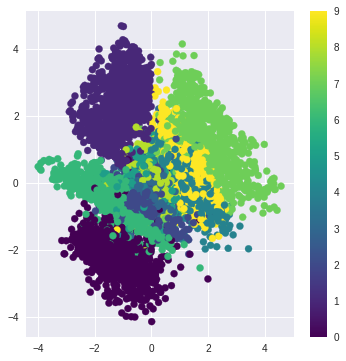

In [27]:
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

## Last but not least, let's generate Figure 2.7.

The only tricky part here is that we have to create a grid over which we interpolate. Which we do by using `np.linspace`, which enables us to move between `min` and `max` value in `step_size`. 

We then just generate a digit for each sample in the for loop and display!

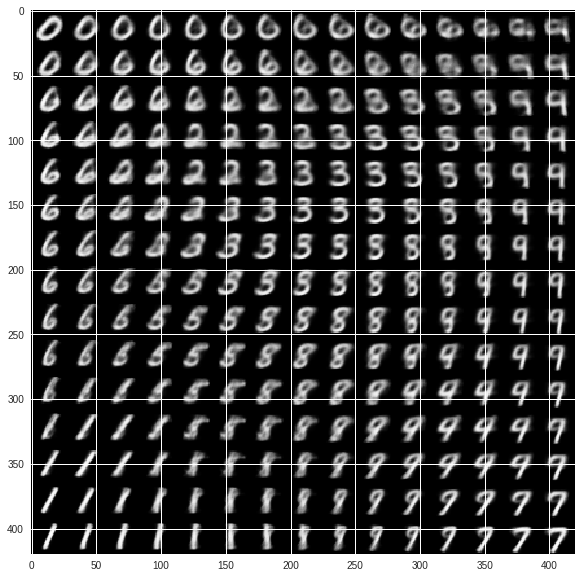

In [22]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()